In [1]:
from scipy.interpolate import interp1d
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import pandas as pd
from fairness import *
import shutil

class EQF:
    def __init__(self, 
                 sample_data):
        self._calculate_eqf(sample_data)

    def _calculate_eqf(self,sample_data):
        sorted_data = np.sort(sample_data)
        linspace  = np.linspace(0,1,num=len(sample_data))
        self.interpolater = interp1d(linspace, sorted_data)
        self.min_val = sorted_data[0]
        self.max_val = sorted_data[-1]

    def __call__(self, value_):
        try:
            return self.interpolater(value_)
        except ValueError:
            if value_ < self.min_val:
                return 0.0
            elif value_ > self.max_val:
                return 1.0
            else:
                raise ValueError('Error with input value')

def get_fairness_objects(sensitive_vector,
                         predictions_s_0, 
                         predictions_s_1):
    
    # calculate CDF and quantile function
    ecdf_dict = {}
    eqf_dict = {}
    pi_dict = {}

    ecdf_dict['p_non_sensitive'] = ECDF(predictions_s_0.reshape(-1,))
    ecdf_dict['p_sensitive'] = ECDF(predictions_s_1.reshape(-1,))

    eqf_dict['p_non_sensitive'] = EQF(predictions_s_0.reshape(-1,))
    eqf_dict['p_sensitive'] = EQF(predictions_s_1.reshape(-1,))

    pi_dict['p_non_sensitive'] = sensitive_vector[sensitive_vector == 0.0].shape[0] / sensitive_vector.shape[0]
    pi_dict['p_sensitive'] = 1-pi_dict['p_non_sensitive']

    return pi_dict, ecdf_dict, eqf_dict





def read_data(path_base, model , task, sens_dict):
    df_train = pd.read_csv(path_base +'/DATA_VLDB/'+ task  + '/train.csv')
    scores_train = pd.read_csv(path_base+'/VLDB_RES/'+task+'_'+model+'/score_train.csv')
    sens_train = make_sens_vector(df_train, task, sens_dict) 
   
    df_valid = pd.read_csv(path_base+'/DATA_VLDB/' + task  + '/valid.csv')
    scores_valid = pd.read_csv(path_base+'/VLDB_RES/'+task+'_'+model+'/score_valid.csv')
    sens_valid = make_sens_vector(df_valid, task, sens_dict) 


    df_train = pd.concat([df_train, df_valid])
    scores_train = pd.concat([scores_train, scores_valid])
    sens_train = np.concatenate((sens_train,sens_valid ))

    df_test = pd.read_csv(path_base +'/DATA_VLDB/'+ task  + '/test.csv')
    scores_test = pd.read_csv(path_base+'/VLDB_RES/'+task+'_'+model+'/score_test.csv')
    sens_test = make_sens_vector(df_test, task, sens_dict) 
    
    TRAIN = [df_train, scores_train, sens_train ]
    TEST = [df_test, scores_test, sens_test ]

    return TRAIN, TEST


import time
def get_fair_estimation(p_dict, 
                        ecdf_dict, 
                        eqf_dict,
                        predictions_nonsensitve, 
                        predictions_sensitve,
                        jitter=0.0001):
    
    # sample jitters
    # np.random.seed(seed)
    
    np.random.seed(int(time.time()))
    jitter_matrix = np.random.uniform(-jitter, 
                                    jitter, 
                                    (predictions_sensitve.shape[0] + 
                                            predictions_nonsensitve.shape[0]))
    
    # # ECDF-ified vals
    # f_preds_nonsensitive = ecdf_dict['p_non_sensitive'](predictions_nonsensitve+ jitter_matrix[:len(predictions_nonsensitve)])
    # f_preds_sensitive = ecdf_dict['p_sensitive'](predictions_sensitve+ jitter_matrix[len(predictions_nonsensitve):])

    # ECDF-ified vals
    f_preds_nonsensitive = ecdf_dict['p_non_sensitive'](predictions_nonsensitve)
    f_preds_sensitive = ecdf_dict['p_sensitive'](predictions_sensitve)


    # non-sensitive return value
    vals_1 = np.zeros_like(predictions_nonsensitve)
    vals_1 += p_dict['p_non_sensitive']*eqf_dict['p_non_sensitive'](f_preds_nonsensitive)
    vals_1 += p_dict['p_sensitive']*eqf_dict['p_sensitive'](f_preds_nonsensitive)

    # sensitive return value
    vals_2 = np.zeros_like(predictions_sensitve)
    vals_2 += p_dict['p_non_sensitive']*eqf_dict['p_non_sensitive'](f_preds_sensitive)
    vals_2 += p_dict['p_sensitive']*eqf_dict['p_sensitive'](f_preds_sensitive)


    return vals_1, vals_2


from sklearn.metrics import roc_curve, auc

def _stats_(sens_array,prob_array, y_array):

    prob_minor = prob_array[sens_array ==1]
    prob_major = prob_array[sens_array ==0]


    y_minor = y_array[sens_array ==1]
    y_major = y_array[sens_array ==0]


    DP, EO, EOD =[], [], []
    PR_minor_all =[]
    TPR_minor_all =[]

    PR_major_all =[]
    TPR_major_all =[]



    fpr, tpr, _ = roc_curve(y_array, prob_array)
    auc_all = 100*auc(fpr, tpr)


    fpr, tpr, _ = roc_curve(y_major, prob_major)
    auc_major = 100*auc(fpr, tpr) 



    N = 500
    
    for theta in np.linspace(0, 1, N):

        y_pred = np.array([1 if score > theta else 0 for score in prob_minor])
        tn, fp, fn, tp = confusion_matrix(y_minor, y_pred).ravel()
        tpr = tp / (tp + fn)
        pr = (tp + fp) / len(y_minor)
        fpr = fp / (fp + tn)
        PR_minor, FPR_minor, TPR_minor = pr, fpr, tpr
        PR_minor_all.append(PR_minor)
        TPR_minor_all.append(TPR_minor)

        y_pred = np.array([1 if score > theta else 0 for score in prob_major])
        tn, fp, fn, tp = confusion_matrix(y_major, y_pred).ravel()
        tpr = tp / (tp + fn)
        pr = (tp + fp) /len(y_major)
        fpr = fp / (fp + tn)
        PR_major, FPR_major, TPR_major = pr, fpr, tpr
        PR_major_all.append(PR_major)
        TPR_major_all.append(TPR_major)

        EOD.append((np.abs(TPR_major - TPR_minor) + np.abs(FPR_major - FPR_minor)))
        EO.append(np.abs(TPR_major - TPR_minor))
        DP.append(np.abs(PR_major-PR_minor))

    DSP_EOD = 100*np.average(EOD) 
    DSP_EO = 100*np.average(EO)
    DSP_DP = 100*np.average(DP)
    Frac = np.linspace(0, 1, N)

    return DSP_EOD, DSP_EO, DSP_DP, auc_all, Frac





def _stats_plot_(sens_array,prob_array, y_array):

    prob_minor = prob_array[sens_array ==1]
    prob_major = prob_array[sens_array ==0]


    y_minor = y_array[sens_array ==1]
    y_major = y_array[sens_array ==0]


    DP, EO, EOD =[], [], []
    PR_minor_all =[]
    TPR_minor_all =[]
    FPR_minor_all =[]

    PR_major_all =[]
    TPR_major_all =[]
    FPR_major_all =[]



    fpr, tpr, _ = roc_curve(y_array, prob_array)
    auc_all = 100*auc(fpr, tpr)


    fpr, tpr, _ = roc_curve(y_major, prob_major)
    auc_major = 100*auc(fpr, tpr) 



    N = 500
    
    for theta in np.linspace(0, 1, N):

        y_pred = np.array([1 if score > theta else 0 for score in prob_minor])
        tn, fp, fn, tp = confusion_matrix(y_minor, y_pred).ravel()
        tpr = tp / (tp + fn)
        pr = (tp + fp) / len(y_minor)
        fpr = fp / (fp + tn)
        PR_minor, FPR_minor, TPR_minor = pr, fpr, tpr
        PR_minor_all.append(PR_minor)
        TPR_minor_all.append(TPR_minor)
        FPR_minor_all.append(FPR_minor)

        y_pred = np.array([1 if score > theta else 0 for score in prob_major])
        tn, fp, fn, tp = confusion_matrix(y_major, y_pred).ravel()
        tpr = tp / (tp + fn)
        pr = (tp + fp) /len(y_major)
        fpr = fp / (fp + tn)
        PR_major, FPR_major, TPR_major = pr, fpr, tpr
        PR_major_all.append(PR_major)
        TPR_major_all.append(TPR_major)
        FPR_major_all.append(FPR_major)

        EOD.append((np.abs(TPR_major - TPR_minor) + np.abs(FPR_major - FPR_minor)))
        EO.append(np.abs(TPR_major - TPR_minor))
        DP.append(np.abs(PR_major-PR_minor))

    DSP_EOD = 100*np.average(EOD) 
    DSP_EO = 100*np.average(EO)
    DSP_DP = 100*np.average(DP)
    Frac = np.linspace(0, 1, N)


    return TPR_major_all, FPR_major_all, TPR_minor_all, FPR_minor_all, Frac



In [3]:

with open('saved_params/sens_attr_dict_valid.pkl', 'rb') as file:
    sens_attr_dict_valid = pickle.load(file)

with open('saved_params/sens_attr_dict_train.pkl', 'rb') as file:
    sens_attr_dict_train = pickle.load(file)

with open('saved_params/repair_label_wise_result.pkl', 'rb') as file:
    thresh_lbl = pickle.load(file)




Before: 0.6923076923076923
Amazon-Google HierGAT 11.06 14.97 19.51 96.9261486988539
After:  EOD
Amazon-Google HierGAT 8.38 | eo 5.22 | eod 7.52 96.79549445212388

Before: 0.641025641025641
Amazon-Google HierGAT 11.06 14.97 19.51 96.9261486988539
After:  EO
Amazon-Google HierGAT 8.9 | eo 6.24 | eod 8.96 96.82351402846788

-------


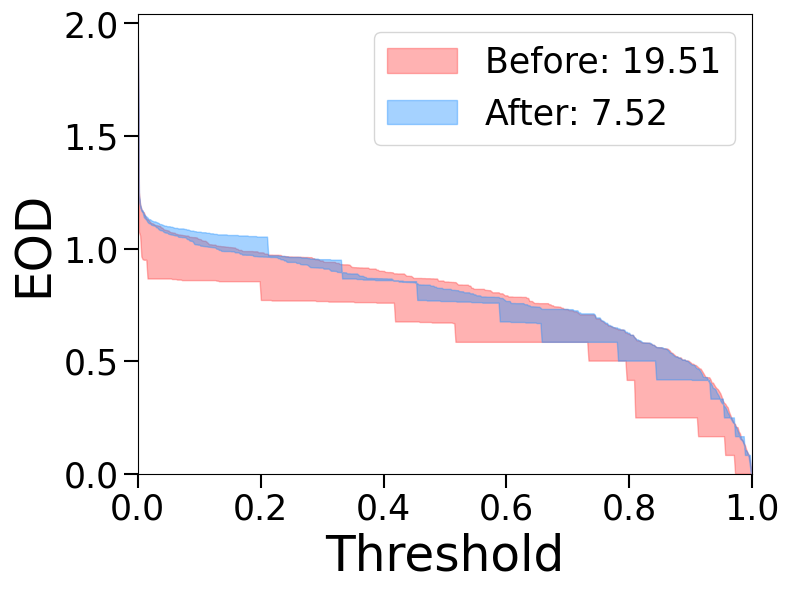

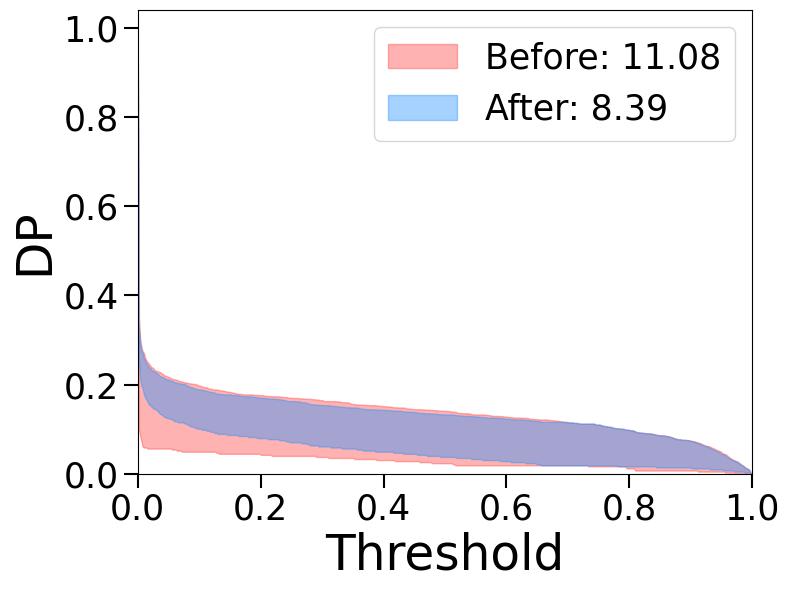

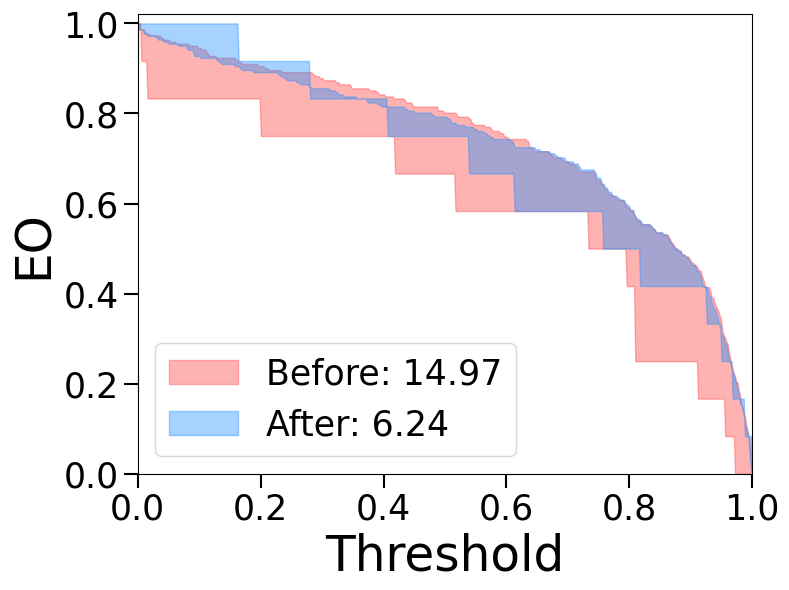

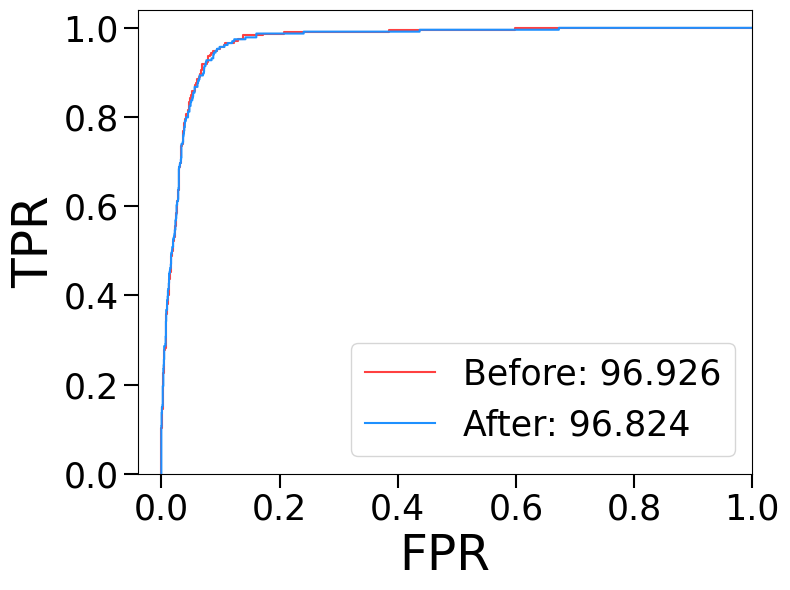

In [9]:
import numpy as np
import pandas as pd
from fairness import *
import pickle


# with open('sens_attr_dict_valid.pkl', 'rb') as file:
#     sens_attr_dict_valid = pickle.load(file)

# with open('sens_attr_dict_train.pkl', 'rb') as file:
#     sens_attr_dict_train = pickle.load(file)

# with open('repair_label_wise_result.pkl', 'rb') as file:
#     thresh_lbl = pickle.load(file)




RES = {}

result_dict = {}
path_base = os.getcwd()

tasks = [ 'Fodors-Zagat','DBLP-GoogleScholar', 'iTunes-Amazon', 'Walmart-Amazon', 'Amazon-Google','Beer','DBLP-ACM']
models = ['deepmatcher', 'DITTO', 'EMTransformer', 'HierGAT','HierMatcher']


# tasks= ['iTunes-Amazon']
# models = ['HierGAT']


plots_res = {}

RES = {}




for task in tasks:
    for model in models:


        # if model +'_'+task not in ['HierGAT_Amazon-Google', 'DITTO_DBLP-GoogleScholar', 'deepmatcher_DBLP-ACM','HierMatcher_DBLP-GoogleScholar', 'HierGAT_DBLP-GoogleScholar' ,'EMTransformer_Amazon-Google']:
        if model +'_'+task not in ['HierGAT_Amazon-Google']:
            continue

        for rpt in ['EOD','EO']:
                
   
            if rpt == 'EO':
                K = 'EO_min'
            else:
                K = 'EOD_min'


            TH = thresh_lbl[task][model][K]['after']['gamma']

            with open('saved_params/sens_attr_dict_test.pkl', 'rb') as file:
                sens_attr_dict_test = pickle.load(file)

            result_dict = {}
            path_base = os.getcwd()




                
            df_test = pd.read_csv(path_base +'/DATA_VLDB/'+ task  + '/test.csv')
            scores_test = pd.read_csv(path_base+'/VLDB_RES/'+task+'_'+model+'/score_test.csv')
            sens_test = sens_attr_dict_test[task]
            




            for x in list(scores_test.columns):
                if len(np.unique(scores_test[x])) >2:  
                    prob_test = scores_test[x]
                else: 
                    y_test = scores_test[x]

            

            print('Before:', TH)
            DSP_EOD, DSP_EO, DSP_DP, auc_all, Frac = _stats_(sens_test,prob_test, y_test)
            print(task, model, round(DSP_DP,2), round(DSP_EO,2), round(DSP_EOD,2), auc_all)


            jitter = 0
            prob_test2 = prob_test + np.random.uniform(-jitter, jitter, prob_test.shape)



            prob_test2_ = prob_test2[prob_test2 > TH]
            sens_test_ = sens_test[prob_test2 > TH]

            p1_pos, e1_pos, q1_pos = get_fairness_objects(
            sens_test_, 
            np.array(prob_test2_[sens_test_ == 0]),  # non-sensitive = 0
            np.array(prob_test2_[sens_test_ == 1])   # sensitive = 1
         )




            prob_test2_ = prob_test2[prob_test2 <= TH]
            sens_test_ = sens_test[prob_test2 <= TH]

            p1_neg, e1_neg, q1_neg = get_fairness_objects(
            sens_test_, 
            np.array(prob_test2_[sens_test_ == 0]),  # non-sensitive = 0
            np.array(prob_test2_[sens_test_ == 1])   # sensitive = 1
         )




            CALIBRATED = []
            for idx, pnt in enumerate(prob_test):
                if sens_test[idx] ==1:
                    in_0 = (np.array([])).reshape(-1,)
                    in_1 = (np.array([pnt])).reshape(-1,)
                else: 
                    in_0 = (np.array([pnt])).reshape(-1,)
                    in_1 = (np.array([])).reshape(-1,)

                if pnt > TH:
                    fair_nonsensitive, fair_sensitive = get_fair_estimation(
                        p1_pos, e1_pos, q1_pos, 
                        in_0, in_1, 
                        jitter= jitter)
                    

                else:
                    fair_nonsensitive, fair_sensitive = get_fair_estimation(
                        p1_neg, e1_neg, q1_neg, 
                        in_0, in_1, 
                        jitter= jitter)
                
                if list(fair_sensitive) ==[]:
                    CALIBRATED.append(list(fair_nonsensitive)[0])
                else:
                    CALIBRATED.append(list(fair_sensitive)[0])

            


            pred_fair = pd.DataFrame(prob_test.copy())
            pred_fair['calibrated'] = CALIBRATED

            if (np.sum(pred_fair['calibrated'] < 0) + np.sum(pred_fair['calibrated'] > 1)) > 0 :
                min_val = pred_fair['calibrated'].min()
                pred_fair['calibrated'] = pred_fair['calibrated']  - min_val
                max_val = pred_fair['calibrated'].max()
                pred_fair['calibrated'] = pred_fair['calibrated'] / max_val


            DSP_EOD2, DSP_EO2, DSP_DP2, auc_all2, Frac = _stats_(sens_test,pred_fair['calibrated'], y_test)

            print('After: ', rpt)
            print(task, model, round(DSP_DP2,2), '| eo',round(DSP_EO2,2), '| eod', round(DSP_EOD2,2), auc_all2)



            print()


# ---- # ----# ----# ----# ----# ----# ----# ----# ----# ----# ----# ----# ----
# ---- # ----# ----# ----# ----# ----# ----# ----# ----# ----# ----# ----# ----
# ---- # ----# ----# ----# ----# ----# ----# ----# ----# ----# ----# ----# ----
# ---- # ----# ----# ----# ----# ----# ----# ----# ----# ----# ----# ----# ----




            if model +'_'+task in ['HierGAT_Amazon-Google', 'DITTO_DBLP-GoogleScholar', 'deepmatcher_DBLP-ACM','HierMatcher_DBLP-GoogleScholar', 'HierGAT_DBLP-GoogleScholar' ,'EMTransformer_Amazon-Google']:

                res = np.array(list(pred_fair['calibrated']))



                score_optimal_Eop,score_optimal_Eodd,score_optimal_PR, model,dataset,sens_attr, y_true, score= res,res,res, model,task,sens_test, np.array(y_test), np.array(pred_fair[pred_fair.columns[0]])



                y_score = score



                Eodd_disp_init = calc_EO_disp(sens_attr, y_true, y_score)
                auc_init = roc_auc_score(y_true, y_score)
                PR_disp_init = calc_DP_PR(sens_attr, y_true, y_score)
                Eop_disp_init = calc_DP_TPR(sens_attr, y_true, y_score)


                range = np.linspace(0, 1, 500)
                Eop_disp = calc_DP_TPR(sens_attr, y_true, score_optimal_Eop)
                auc_Eop = roc_auc_score(y_true, score_optimal_Eop)

                E_op_g1,E_op_g2 =[], []
                for TH in range:
                    y_pred = np.array([1 if score > TH else 0 for score in y_score])
                    E_op_g1, E_op_g2,_, _ = E_make(E_op_g1, E_op_g2,[], [], y_true,y_pred,  sens_attr)


                E_op_g1_calib,E_op_g2_calib =[], []
                for TH in range:
                    y_pred = np.array([1 if score > TH else 0 for score in score_optimal_Eop])
                    E_op_g1_calib, E_op_g2_calib,_, _ = E_make(E_op_g1_calib, E_op_g2_calib,[], [], y_true,y_pred,  sens_attr)
                    

                AUC_init ,_, _ = AUC_make(y_true, y_score, sens_attr)
                AUC_Eop ,_, _ = AUC_make(y_true, score_optimal_Eop, sens_attr)


                ########################################  

                Eodd_disp = calc_EO_disp(sens_attr, y_true, score_optimal_Eodd)
                auc_Eodd = roc_auc_score(y_true, score_optimal_Eodd)
                AUC_Eod ,_, _ = AUC_make(y_true, score_optimal_Eodd, sens_attr)


                E_od_g1, E_od_g2 =[], []
                for TH in range:
                    y_pred = np.array([1 if score > TH else 0 for score in y_score])
                    _, _,E_od_g1, E_od_g2 = E_make([], [],E_od_g1, E_od_g2, y_true,y_pred,  sens_attr)
                    
                E_od_g1_calib, E_od_g2_calib =[], []
                for TH in range:
                    y_pred = np.array([1 if score > TH else 0 for score in score_optimal_Eodd])
                    _, _,E_od_g1_calib, E_od_g2_calib = E_make([], [],E_od_g1_calib, E_od_g2_calib, y_true,y_pred,  sens_attr)
                    


                ########################################  

                PR_disp = calc_DP_PR(sens_attr, y_true, score_optimal_PR)
                auc_PR = roc_auc_score(y_true, score_optimal_PR)


                AUC_PR ,_, _ = AUC_make(y_true, score_optimal_PR, sens_attr)


                PR_g1, PR_g2 = [], []

                for TH in range:
                    y_pred = np.array([1 if score > TH else 0 for score in y_score])
                    _, PR_g1, PR_g2 = PR_make([], PR_g1, PR_g2,y_true, y_pred , sens_attr)



                PR_g1_calib, PR_g2_calib = [], []
                for TH in range:
                    y_pred = np.array([1 if score > TH else 0 for score in score_optimal_PR])
                    _, PR_g1_calib, PR_g2_calib = PR_make([], PR_g1_calib, PR_g2_calib,y_true, y_pred , sens_attr)





                L = 1.5
                F = 25
                F_legend = 28
                F_title = 35
                size = (8,6)
                # size = (10,9)
        #         size = (32+3,24+3)
        #         size = (12+3,10+2)



                tick_l = 10
                tick_w = 1.5
                F_ax = 25
                F_lbl = 35

                fig_alpha = 0.65
                F_legend = 25


                if rpt == 'EOD':
                    plt.figure(figsize=size)
                    # plt.subplot(222)
                    plt.xticks(fontsize = F)
                    plt.yticks(fontsize = F)
                    plt.fill_between(range, E_od_g1,E_od_g2, color='#FF4040', alpha=0.4, label = 'Before: '+ str(round(DSP_EOD,2)))
                    plt.fill_between(range, E_od_g1_calib,E_od_g2_calib, color='#1E90FF', alpha=0.4, label = 'After: '+ str(round(DSP_EOD2,2)))
                    plt.ylabel('EOD', fontsize = F_title)
                    plt.xlabel('Threshold', fontsize =F_title)  
                    plt.legend(fontsize = F_legend, loc = 'best')
                    plt.ylim([0,2.04])
                    plt.xlim([0,1])
                    plt.tick_params(axis='both', which='both', length=tick_l, width=tick_w)



                    y_ticks = plt.yticks()[0]
                    half_y_ticks = y_ticks[::2]  # Select every other y-tick
                    plt.yticks(half_y_ticks)
                    plt.tight_layout()
                    plt.savefig('FIGURES/EOD_'+str(model)+'_'+str(dataset)+'alg2.pdf')
                    # plt.close()
                    


                    plt.figure(figsize=size)
                    # plt.subplot(223)
                    plt.xticks(fontsize = F)
                    plt.yticks(fontsize = F)
                    plt.fill_between(range, PR_g2,PR_g1, color='#FF4040', alpha=0.4, label = 'Before: '+ str(round(100*PR_disp_init,2)))
                    plt.fill_between(range, PR_g1_calib,PR_g2_calib, color='#1E90FF', alpha=0.4, label = 'After: '+ str(round(100*PR_disp,2)))
                    plt.ylabel('DP', fontsize = F_title)
                    plt.xlabel('Threshold', fontsize =F_title)  
                    plt.legend(fontsize = F_legend, loc = 'best')
                    plt.ylim([0,1.04])
                    plt.xlim([0,1])
                    plt.tick_params(axis='both', which='both', length=tick_l, width=tick_w)

                    plt.tight_layout()
                    plt.savefig('FIGURES/PR_'+str(model)+'_'+str(dataset)+'alg2.pdf')
                    # plt.close()

                if rpt == 'EO':
                    plt.figure(figsize=size)
                    # plt.subplot(221)
                    plt.xticks(fontsize = F)
                    plt.yticks(fontsize = F)
                    plt.fill_between(range, E_op_g1,E_op_g2, color='#FF4040', alpha=0.4, label = 'Before: '+ str(round(DSP_EO,2)))
                    plt.fill_between(range, E_op_g1_calib,E_op_g2_calib, color='#1E90FF', alpha=0.4, label = 'After: '+ str(round(DSP_EO2,2)))
                    plt.ylabel('EO', fontsize = F_title)
                    plt.xlabel('Threshold', fontsize =F_title)  
                    plt.ylim([0,1.02])
                    plt.xlim([0,1])
                    plt.tick_params(axis='both', which='both', length=tick_l, width=tick_w)

                    plt.tight_layout()
                    plt.legend(loc = 'lower left',fontsize = F_legend)
                    plt.savefig('FIGURES/EO'+'_'+str(model)+'_'+str(dataset)+'alg2.pdf')
                    # plt.close()



                    plt.figure(figsize=size)
                    # plt.subplot(224)
                    plt.xticks(fontsize = F)
                    plt.yticks(fontsize = F)
                    plt.plot(AUC_init[0],AUC_init[1],label = 'Before: '+str(round(100*auc_init,3)), color = '#FF4040', linewidth = L) 
                    plt.plot(AUC_Eod[0],AUC_Eod[1],label = 'After: '+str(round(100*auc_Eop,3)), color = '#1E90FF', linewidth = L) 
                    plt.legend(fontsize = F_legend, loc = 'best')
                    plt.xlabel('FPR', fontsize =F_title)  
                    plt.ylabel('TPR', fontsize =F_title)    
                    plt.ylim([0,1.04])
                    plt.xlim([0-0.04,1])
                    # plt.tick_params(axis='both', which='both', length=10, width=1.5)
                    plt.tick_params(axis='both', which='both', length=tick_l, width=tick_w)

                    plt.tight_layout()
                    plt.savefig('FIGURES/AUC_'+str(model)+'_'+str(dataset)+'alg2.pdf')
                    # plt.savefig('FIGURES/'+str(model)+'_'+str(dataset)+'alg2.pdf')
                    # plt.close()







        print('-------')
